In [4]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split

def load_data_from_csv(csv_path, images_path, target_size=(128, 128), color_mode='grayscale'):
    data = pd.read_csv(csv_path)
    faces = []
    labels = []

    for index, row in data.iterrows():
        image_path = os.path.join(images_path, row['id'])
        label = row['label']

        image = tf.io.read_file(image_path)
        if color_mode == 'rgb':
            image = tf.image.decode_jpeg(image, channels=3)
        else:
            image = tf.image.decode_jpeg(image, channels=1)
            image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB

        image = tf.image.resize(image, target_size)
        image = tf.image.convert_image_dtype(image, tf.float32)

        faces.append(image)
        labels.append(label)

    return faces, labels

# Load and preprocess data
faces, labels = load_data_from_csv("data/Dataset.csv", "data/Faces/Faces", target_size=(224, 224), color_mode='rgb')

# Convert labels to numerical values
unique_labels = list(set(labels))
label_map = {label: index for index, label in enumerate(unique_labels)}
labels = [label_map[label] for label in labels]

faces = tf.stack(faces)
labels = tf.constant(labels)

train_indices, val_indices = train_test_split(range(len(faces)), test_size=0.2, random_state=42)
train_faces = tf.gather(faces, train_indices)
train_labels = tf.gather(labels, train_indices)
val_faces = tf.gather(faces, val_indices)
val_labels = tf.gather(labels, val_indices)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_faces, train_labels)).map(augment).shuffle(buffer_size=len(train_faces)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_faces, val_labels)).batch(32)


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

def get_model(use_pretrained=False, input_shape=(224, 224, 3), num_classes=5):
    if use_pretrained:
        # Use VGG16 as base model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        for layer in base_model.layers[:-4]:
            layer.trainable = False

        # Add custom layers on top of VGG16
        x = base_model.output
        x = Flatten()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)
    else:
        # Define a simple custom model
        inputs = Input(shape=input_shape)
        x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs, outputs=x)

    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
use_pretrained = True  # Set to False to use the custom model

# Get the model
model = get_model(use_pretrained=use_pretrained, input_shape=(224, 224, 3), num_classes=len(unique_labels))

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

# Evaluate the model
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.0454 - loss: 6.4955 - val_accuracy: 0.0448 - val_loss: 3.4267
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.0485 - loss: 3.5297 - val_accuracy: 0.0448 - val_loss: 3.4179
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.0532 - loss: 4.9911 - val_accuracy: 0.0448 - val_loss: 3.4111
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.0522 - loss: 3.4112 - val_accuracy: 0.0448 - val_loss: 3.4053
Epoch 5/20
 8/65 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.0514 - loss: 3.4102

In [9]:
# from tensorflow.keras.callbacks import LearningRateScheduler
#
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return float(lr * tf.math.exp(-0.1))
#
# lr_scheduler = LearningRateScheduler(scheduler)


#### TEST FOR CONV NETWORKS

In [4]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.0742 - loss: 190.4129 - val_accuracy: 0.2846 - val_loss: 2.6367
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.5687 - loss: 1.6128 - val_accuracy: 0.3821 - val_loss: 2.7799
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.8463 - loss: 0.5847 - val_accuracy: 0.3938 - val_loss: 3.1390
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8376 - loss: 0.5890 - val_accuracy: 0.3860 - val_loss: 3.8550
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9664 - loss: 0.1428 - val_accuracy: 0.4094 - val_loss: 3.9112
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9942 - loss: 0.0455 - val_accuracy: 0.4191 - val_loss: 4.0406
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.9973 - loss: 0.0125 - val_accuracy: 0.4269 - val_loss: 4.1792
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9948 - loss: 0.0419 - val_accuracy: 

In [5]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4492 - loss: 5.4798
Validation Loss: 5.1464009284973145, Validation Accuracy: 0.46198830008506775


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


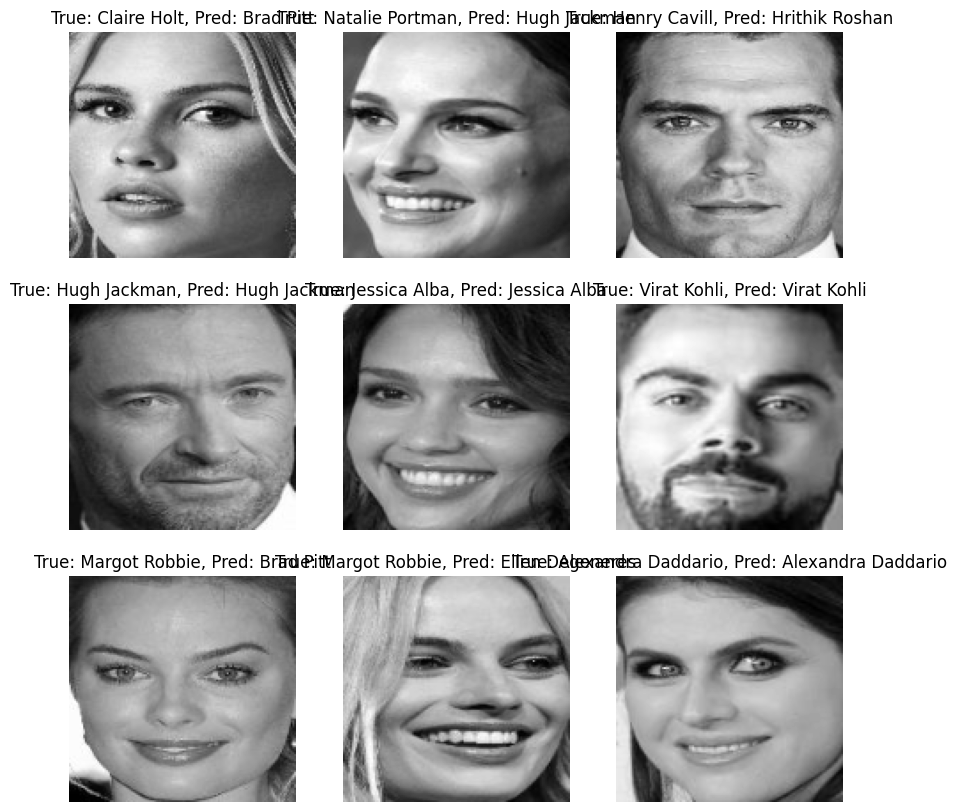

In [37]:
import matplotlib.pyplot as plt

def plot_predictions(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().reshape(128, 128), cmap='gray')
        plt.title(f"True: {unique_labels[labels[i]]}, Pred: {unique_labels[predictions[i]]}")
        plt.axis('off')
    plt.show()

# Get some images and their labels from the validation set
val_images, val_labels = next(iter(val_dataset))

# Make predictions
predictions = tf.argmax(model.predict(val_images), axis=1).numpy()

# Plot the results
plot_predictions(val_images, val_labels, predictions)
